In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

x_int = torch.load('x_int.pt')[:32]

print(x_int.shape)

torch.Size([32, 12, 197, 197])


In [2]:
def log2_int_10x(x):
    # UINT16 입력값을 정수형으로 변환
    x = x.to(torch.int32)

    # x가 0인 경우를 처리하기 위해 결과를 미리 -1로 초기화합니다.
    log2_int = torch.full_like(x, -1, dtype=torch.int32)
    # dja = bits_required(x)
    # print(dja)
    # 1. log2의 정수 부분 계산
    temp_x = x.clone()
    for i in range(15, -1, -1):
        shift = 1 << i
        greater_equal = temp_x >= shift
        log2_int += greater_equal.to(torch.int32)
        temp_x = temp_x >> greater_equal.to(torch.int32)
    # print(log2_int)
    # 2. 소수점 아래 한 자리 계산 (0.1, 0.2, ..., 0.9를 정수로 근사)
    # 0.1 ~ 0.9에 해당하는 상수 값을 정수로 표현
    fractional_add = torch.zeros_like(x, dtype=torch.int32)

    # 0.5 추가 (0.1 * 5)
    temp_x = x - (1 << log2_int)
    temp_x = temp_x << 1  # temp_x *= 2
    fractional_add += (temp_x >= (1 << log2_int)).to(torch.int32) * 5

    # # 0.2 추가 (0.1 * 2)
    # temp_x = x - (1 << log2_int) - (fractional_add >> 1)
    # temp_x = temp_x << 2  # temp_x *= 4
    # fractional_add += (temp_x >= (1 << log2_int)).to(torch.int32) * 2

    # # 0.1 추가
    # temp_x = x - (1 << log2_int) - ((fractional_add * 3) >> 2)
    # temp_x = temp_x << 3  # temp_x *= 8
    # fractional_add += (temp_x >= (1 << log2_int)).to(torch.int32) * 1

    # 최종 log2 값은 정수 부분과 fractional_add를 합친 것입니다.
    return log2_int * 10 + fractional_add


def int_huge_16bit_int_to_log(x, k):
    """int log2 approximation"""
    x_log2_10x = -1 * log2_int_10x(x)  # [0, 15.5] * 10
    # print(x_log2_10x.unique())
    return x_log2_10x * (2 ** (16 - k) / 10).round()

    # """fp int log2"""
    # x_log2 = (x.log2() * 2).floor() / 2  # [0, 15.5]
    # # print(x_log2_10x.unique())
    # return x_log2 * round_ste.apply(2 ** (self.pre_bits - k))

    """
    (-1 * torch.log2(x)).round() * 2 ** (bits - k)
    2 ** (bits - k) == huge number
    if b == 16, k == 0.7    
    2**(b-k) == 40342.14
    can compute in INT arithmetic
    """

def int_huge_16bit_log_to_int( y, k):
    return 2 ** (-y / 2 ** (16 - k))

In [3]:
pre_bits = torch.tensor(16)
k = torch.tensor(1)
int_bias = torch.tensor(1)

print(f"[1] input min: {x_int.min()}, max: {x_int.max()}")
x_int_biased = x_int + int_bias
print(f"[2] biased min: {x_int_biased.min()}, max: {x_int_biased.max()}")
# [2] log quantization in huge domain
x_int_log_q = int_huge_16bit_int_to_log(x_int_biased, k)
print(f"[3] log quantized min: {x_int_log_q.min()}, max: {x_int_log_q.max()}")

print(f"{x_int_log_q.unique().numel()} unique values")
print(f"{x_int_log_q.unique()}")

# print("[2]")
# print(x_int_log_q.unique().numel())
# print(x_int_log_q.unique())

# [3] log dequantization
# print("[3]")
x_int_log_dq = int_huge_16bit_log_to_int(x_int_log_q, k)
print(f"[4] log dequantized min: {x_int_log_dq.min()}, max: {x_int_log_dq.max()}")
print(x_int_log_dq.unique().numel())
print(x_int_log_dq.unique())

# [4] remove bias
x_int_log_dq = x_int_log_dq - int_bias
print(f"[5] unbiased min: {x_int_log_dq.min()}, max: {x_int_log_dq.max()}")
print(x_int_log_dq.unique().numel())
print(x_int_log_dq.unique())



[1] input min: 0.0, max: 63960.0
[2] biased min: 1.0, max: 63961.0
[3] log quantized min: -507935.0, max: 0.0
31 unique values
tensor([-507935., -491550., -475165., -458780., -442395., -426010., -409625.,
        -393240., -376855., -360470., -344085., -327700., -311315., -294930.,
        -278545., -262160., -245775., -229390., -213005., -196620., -180235.,
        -163850., -147465., -131080., -114695.,  -98310.,  -81925.,  -65540.,
         -49155.,  -32770.,       0.], device='cuda:0')
[4] log dequantized min: 1.0, max: 46371.34765625
31
tensor([1.0000e+00, 2.0001e+00, 2.8286e+00, 4.0003e+00, 5.6575e+00, 8.0010e+00,
        1.1315e+01, 1.6003e+01, 2.2632e+01, 3.2007e+01, 4.5265e+01, 6.4016e+01,
        9.0535e+01, 1.2804e+02, 1.8108e+02, 2.5609e+02, 3.6217e+02, 5.1220e+02,
        7.2437e+02, 1.0244e+03, 1.4488e+03, 2.0490e+03, 2.8977e+03, 4.0981e+03,
        5.7957e+03, 8.1965e+03, 1.1592e+04, 1.6394e+04, 2.3185e+04, 3.2789e+04,
        4.6371e+04], device='cuda:0')
[5] unbiased m

In [4]:
# [5] most biggest 16 values
x_int8_out = (x_int_log_dq / 255).round().clamp(0, 255)
print(f"[6] output min: {x_int8_out.min()}, max: {x_int8_out.max()}")
print(x_int8_out.unique().numel())
print(x_int8_out.unique())

# print("[5]")
# print(x_int8_out.unique().numel())
# print(x_int8_out.unique())

x_int_out = x_int8_out * 255
print(f"[7] output min: {x_int_out.min()}, max: {x_int_out.max()}")
print(x_int_out.unique().numel())
print(x_int_out.unique())

[6] output min: 0.0, max: 182.0
16
tensor([  0.,   1.,   2.,   3.,   4.,   6.,   8.,  11.,  16.,  23.,  32.,  45.,
         64.,  91., 129., 182.], device='cuda:0')
[7] output min: 0.0, max: 46410.0
16
tensor([    0.,   255.,   510.,   765.,  1020.,  1530.,  2040.,  2805.,  4080.,
         5865.,  8160., 11475., 16320., 23205., 32895., 46410.],
       device='cuda:0')


In [5]:
x_int_out.unique()

tensor([    0.,   255.,   510.,   765.,  1020.,  1530.,  2040.,  2805.,  4080.,
         5865.,  8160., 11475., 16320., 23205., 32895., 46410.],
       device='cuda:0')

In [6]:
(x_int_out/255).unique()

tensor([  0.0000,   1.0000,   2.0000,   3.0000,   4.0000,   6.0000,   8.0000,
         11.0000,  16.0000,  23.0000,  32.0000,  45.0000,  64.0000,  91.0000,
        129.0000, 182.0000], device='cuda:0')

In [7]:
x_int_hist = x_int.flatten().cpu().numpy()
x_int_out_hist = x_int_out.flatten().cpu().numpy()

x_int_log_q_map = x_int_log_q.flatten().cpu().numpy()
x_lim = torch.arange(0, len(x_int_log_q_map), 1)


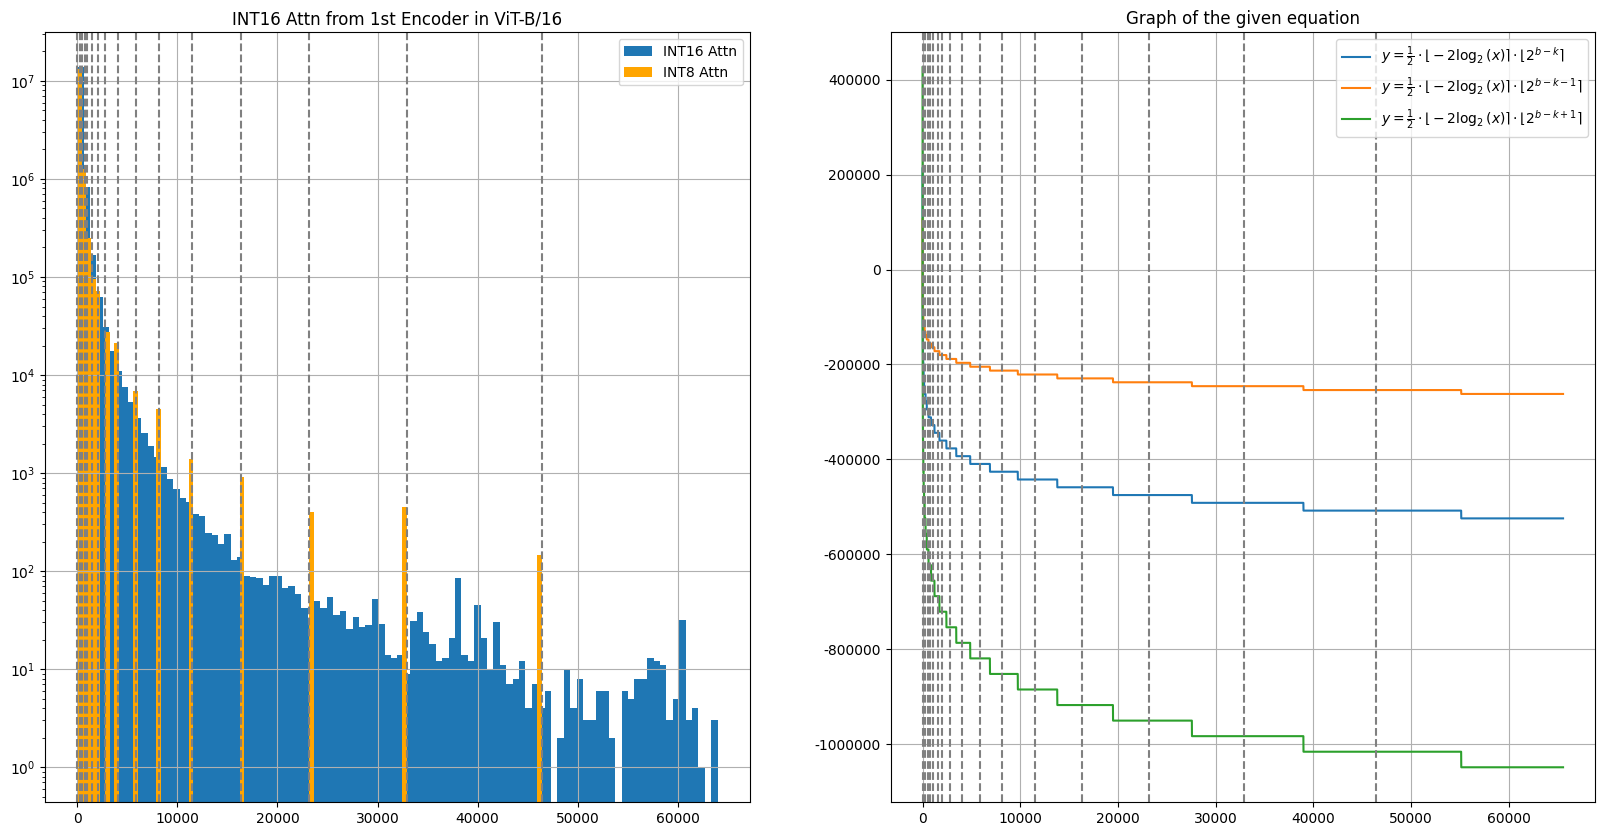

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(x_int_hist, bins=100, label="INT16 Attn")
ax[0].hist(x_int_out_hist, bins=100, color="orange", label="INT8 Attn")
ax[0].set_yscale('log')
ax[0].set_title('INT16 Attn from 1st Encoder in ViT-B/16')
ax[0].grid(True)
ax[0].legend()


x = np.linspace(0.01, 65535, 10000)  # log(x)를 위해 0을 제외하고 설정
y = (np.round(2 * -np.log2(x)) / 2) * np.round(2 ** (pre_bits.numpy() - k.numpy()))
ax[1].plot(
    x,
    y,
    label=r"$y = \frac{1}{2}\cdot{\lfloor-2\log_2(x)\rceil} \cdot \lfloor2^{b-k}\rceil$",
)
y = (np.round(2 * -np.log2(x)) / 2) * np.round(2 ** (pre_bits.numpy() - k.numpy() - 1))
ax[1].plot(
    x,
    y,
    label=r"$y = \frac{1}{2}\cdot{\lfloor-2\log_2(x)\rceil} \cdot \lfloor2^{b-k-1}\rceil$",
)
y = (np.round(2 * -np.log2(x)) / 2) * np.round(2 ** (pre_bits.numpy() - k.numpy() + 1))
ax[1].plot(
    x,
    y,
    label=r"$y = \frac{1}{2}\cdot{\lfloor-2\log_2(x)\rceil} \cdot \lfloor2^{b-k+1}\rceil$",
)
ax[1].set_title("Graph of the given equation")

x_values = x_int_out.unique().cpu().numpy()
for tic in x_values:
    ax[0].axvline(x=tic, color="gray", linestyle="--")#, label=f"x={tic}")
    ax[1].axvline(x=tic, color="gray", linestyle="--")#, label=f"x={tic}")
ax[1].legend()
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax[1].grid(True)
plt.show()

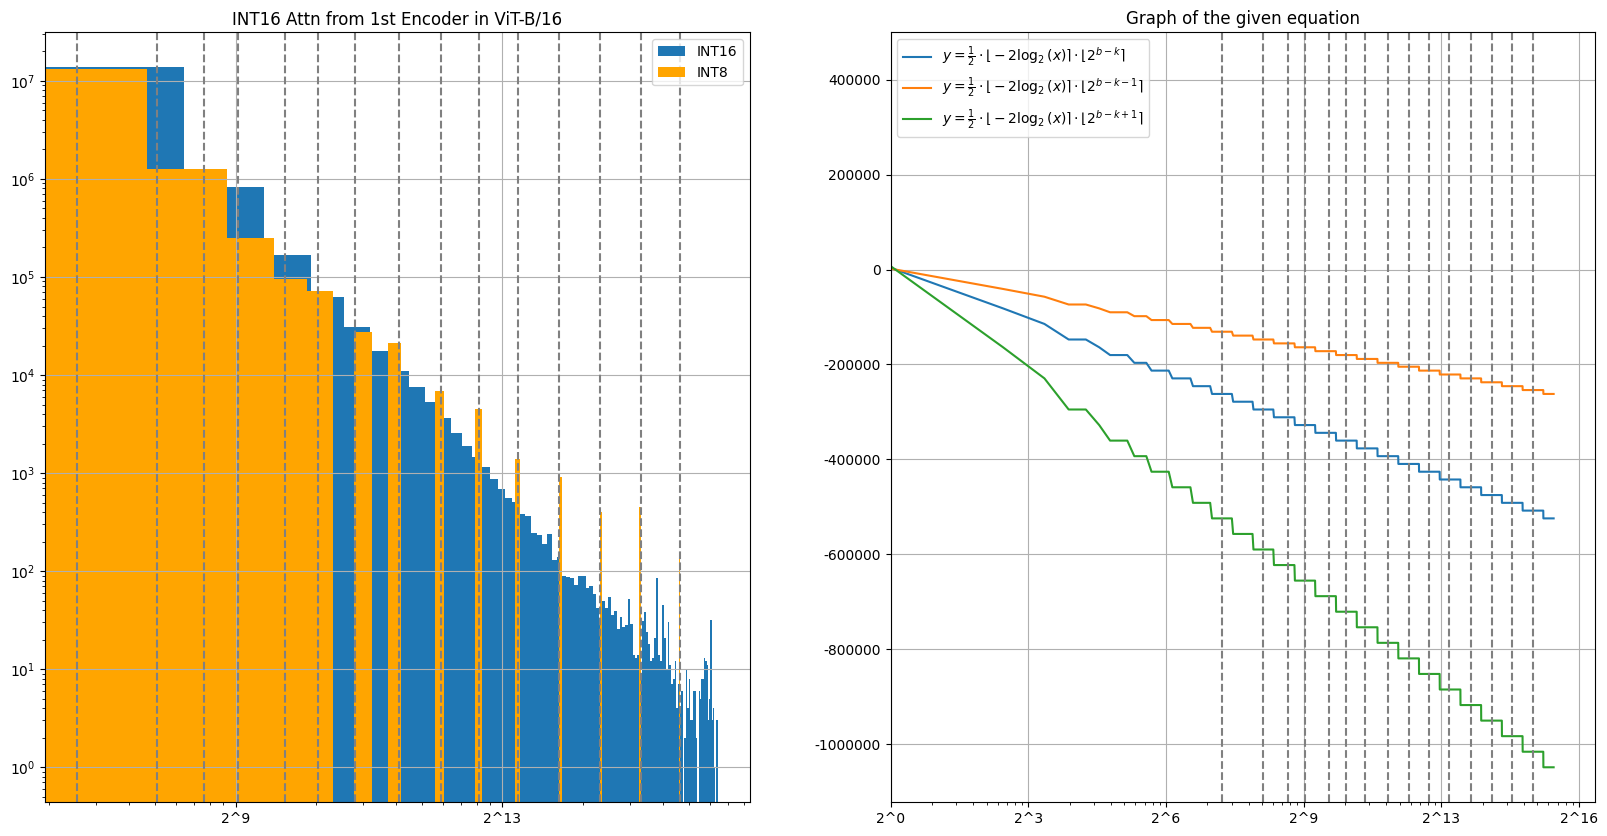

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(x_int_hist, bins=100, label="INT16")
ax[0].hist(x_int_out_hist, bins=100, color="orange", label="INT8")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_title("INT16 Attn from 1st Encoder in ViT-B/16")
ax[0].grid(True)
ax[0].legend()


x = np.linspace(0.01, 2**16, 10000)  # log(x)를 위해 0을 제외하고 설정
y = (np.round(2 * -np.log2(x)) / 2) * np.round(2 ** (pre_bits.numpy() - k.numpy()))
ax[1].plot(
    x,
    y,
    label=r"$y = \frac{1}{2}\cdot{\lfloor-2\log_2(x)\rceil} \cdot \lfloor2^{b-k}\rceil$",
)
y = (np.round(2 * -np.log2(x)) / 2) * np.round(2 ** (pre_bits.numpy() - k.numpy() - 1))
ax[1].plot(
    x,
    y,
    label=r"$y = \frac{1}{2}\cdot{\lfloor-2\log_2(x)\rceil} \cdot \lfloor2^{b-k-1}\rceil$",
)
y = (np.round(2 * -np.log2(x)) / 2) * np.round(2 ** (pre_bits.numpy() - k.numpy() + 1))
ax[1].plot(
    x,
    y,
    label=r"$y = \frac{1}{2}\cdot{\lfloor-2\log_2(x)\rceil} \cdot \lfloor2^{b-k+1}\rceil$",
)
ax[1].set_title("Graph of the given equation")
# ax[1].set_xbound(10000, 65535)
ax[1].set_xlim(1, 2**17)
ax[1].set_xscale("log")

x_values = x_int_out.unique().cpu().numpy()
for tic in x_values:
    ax[0].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")
    ax[1].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")
ax[1].legend()
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax[1].xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"2^{int(np.log2(x))}")
)
ax[0].xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"2^{int(np.log2(x))}")
)
ax[1].grid(True)
plt.show()